<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [6]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [7]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [8]:
# 70% 15% 15%

X_train, y_train = X[:3935], y[:3935]
X_test, y_test = X[3935:4775], y[3935:4775]
X_val, y_val = X[4775:], y[4775:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5), (3935,), (840, 5), (840,), (841, 5), (841,))

In [71]:
from datetime import datetime
from time import time

import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.callbacks import Callback

from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.models import load_model
from keras.utils.vis_utils import plot_model

class Transformer(object):

    def __init__(self):

        self.look_back = 5
        self.n_features = 1
        self.horizon = 1

        self.checkpoint_dir = "checkpoint"

        self.head_size=256
        self.num_heads=16
        self.ff_dim=4
        self.num_transformer_blocks=4
        self.mlp_units=[128]
        self.mlp_dropout=0.4
        self.dropout=0.25


    def transformer_encoder(self,
        inputs):

        # Normalization and Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(
        key_dim=self.head_size, num_heads=self.num_heads, dropout=self.dropout)(x, x)
        x = layers.Dropout(self.dropout)(x)

        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        return x + res


    def build(self):

        inputs = keras.Input(shape=(self.look_back, self.n_features))
        x = inputs
        for _ in range(self.num_transformer_blocks):
            x = self.transformer_encoder(x)

        x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
        for dim in self.mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.mlp_dropout)(x)

        # output layer
        outputs = layers.Dense(self.horizon)(x)

        return keras.Model(inputs, outputs)

    
    def train(self, X_train, y_train, epochs=200, batch_size=128):

        self.model = self.build()
        self.model.compile( loss = MeanSquaredError(), 
                           optimizer = Adam(learning_rate= 0.001), 
                           metrics=['mae',
                                    MeanSquaredError(),
                                    RootMeanSquaredError(),
                                    MeanAbsolutePercentageError()])

        # Stop training if error does not improve within 50 iterations
        early_stopping_monitor = EarlyStopping(patience=2,
                                               restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = self.checkpoint_dir+"/Transformer.best"+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        cp = ModelCheckpoint(filepath,
                                     monitor=MeanAbsolutePercentageError(),
                                     verbose=1,
                                     save_best_only=True,
                                     mode='min')

        callback_history = self.model.fit(X_train, y_train,
                                          epochs=epochs,
                                          batch_size=batch_size,
                                          verbose=1,
                                          callbacks=[early_stopping_monitor,
                                                     cp])


In [51]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE,1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5, 1), (3935,), (840, 5, 1), (840,), (841, 5, 1), (841,))

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [ ]:
## Testing the Transformer
tr = Transformer()
tr.train(X_train,y_train)

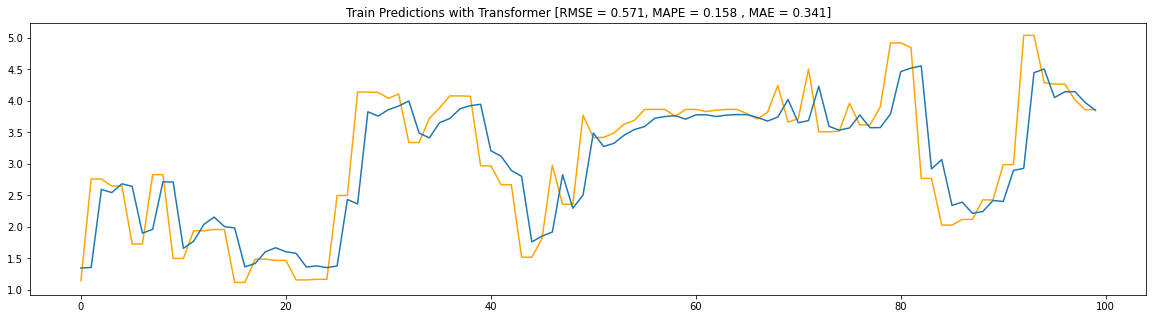

In [66]:
y_pred_train = tr.model.predict(X_train)

y_pred_train = tr.model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train = scaler.inverse_transform(y_pred_train)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_train, Inverse_y_train)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_train[0:100], color='orange')
plt.plot(Inverse_y_pred_train[0:100])
plt.title("Train Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

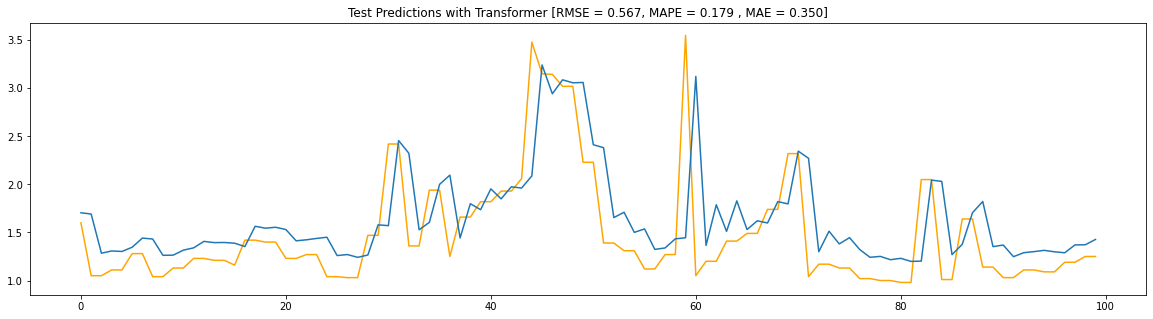

In [67]:
y_pred_test = tr.model.predict(X_test)

y_pred_test = tr.model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test = scaler.inverse_transform(y_pred_test)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test, Inverse_y_test)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_test[0:100], color='orange')
plt.plot(Inverse_y_pred_test[0:100])
plt.title("Test Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

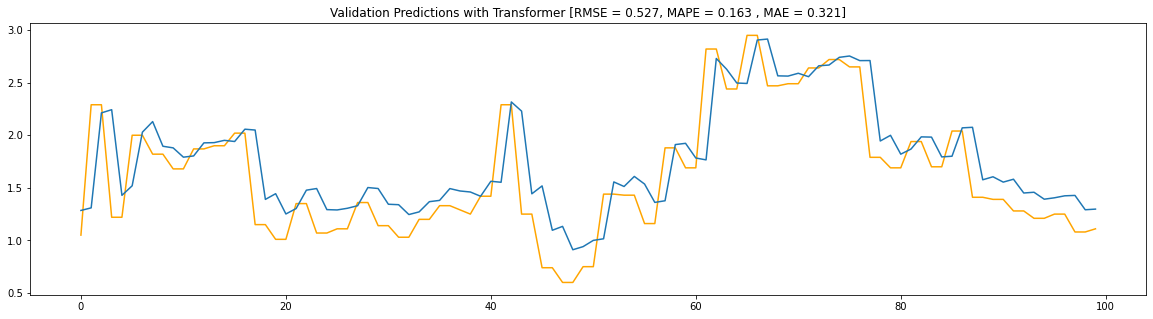

In [68]:
y_pred_val = tr.model.predict(X_val)

y_pred_val = tr.model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val[0:100], color='orange')
plt.plot(Inverse_y_pred_val[0:100])
plt.title("Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

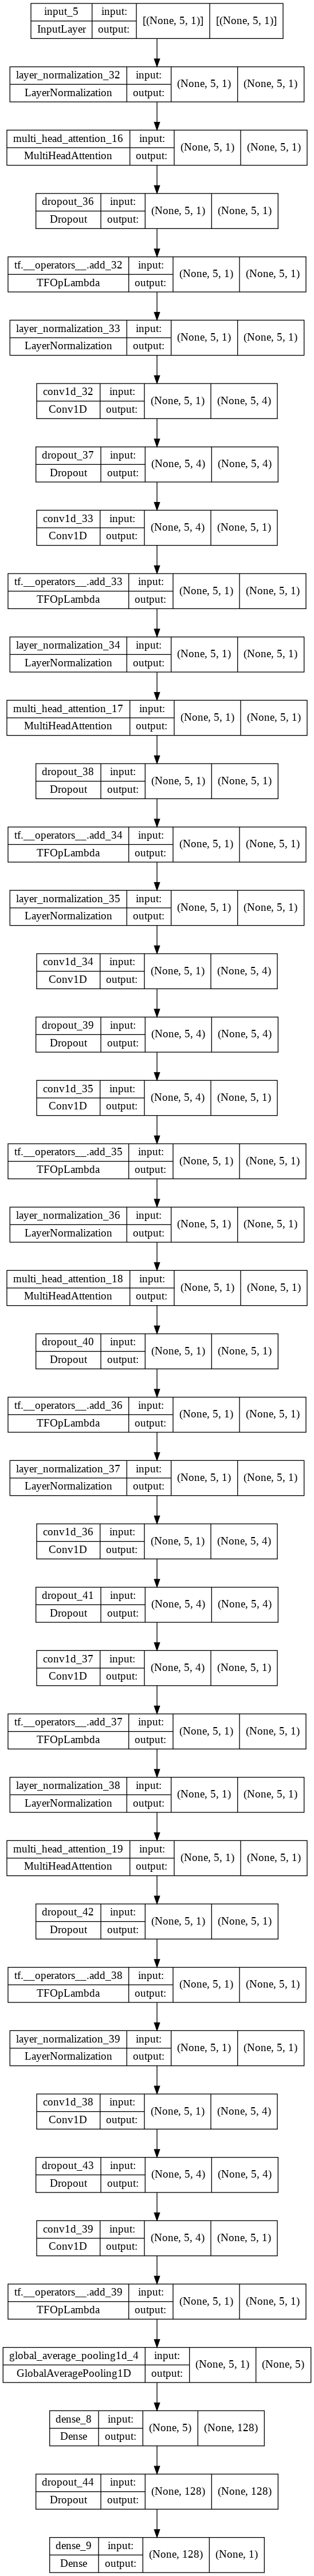

In [74]:
plot_model(tr.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)